## Use Case: Query and inspect metadata table

In [1]:
import datetime as dt

from query.utils import Env
from query.microservices import get_all_metadata

env = Env.STAGING

# Pull all metadata available (around 9000 rows)
metadata_df = get_all_metadata(env)
print(f"{len(metadata_df)} total rows")
metadata_df = metadata_df[metadata_df['start_time'] >= '2024-08-01 00:00:00.517960+00:00']

13588 total rows


In [13]:
from query.microservices import query_relevant_metadata

# Query Parmaeters explained:

# Want all data from month of March (just an exmaple)
start_time = dt.datetime(2024, 8, 1, 18, 15, 0)
end_time = dt.datetime(2024, 8, 1, 18, 25, 0)

# if not worried about protocol information, set drop_duplicate_sessions = True
# If this is false, duplicate session_ids can be on multiple rows.
drop_duplicate_sessions = True

# Only want data from sebrings
model = 'sebring'

relevant_sessions = query_relevant_metadata(metadata_df,
                                            drop_duplicate_sessions = drop_duplicate_sessions,
                                            start_time = start_time,
                                            end_time = end_time,
                                            # model = model,
                                            user_email = 'mikoshilab@pison.com'
                                           )

print(f"Found {len(relevant_sessions)} relevant sessions")
relevant_sessions.head(31)

#Extract session ids
relevant_sessions['session_id'].to_csv('vj_ids.csv')

Found 11 relevant sessions


In [29]:
# Notes:
# Common query columns: session_id, start_time, end_time, user_email, username, model, protocol_id, protocol_name
# the query matching matches subsets, so for example: user_email = 'sam' wil match any subset of email that has 'sam' in it.

## Use Case: Pass metadata subset to bigquery directly

In [7]:
from query.bigquery import PisonQuery
import pandas as pd
from datetime import datetime, timedelta

# Want all data from month of March (just an exmaple)
start_time = dt.datetime(2024, 8, 1, 18, 15, 0)
end_time = dt.datetime(2024, 8, 1, 18, 25, 0)

# after finding the sessions you want via query_relevant_metadata,
# you can pass the subset dataframe directly to bigquey module to pull those sessions
subset_sessions_df = query_relevant_metadata(metadata_df,
                                            # drop_duplicate_sessions = drop_duplicate_sessions,
                                            start_time = start_time,
                                            end_time = end_time,
                                            # model = '',
                                            user_email = 'mikoshilab@pison.com'
                                           )
print(f"Found {len(subset_sessions_df)} relevant sessions")

# same env as above
staging_query = PisonQuery(env = env, dataset = 'pison_dataset')

subset_sessions_df['model'] = 'sebring'
subset_sessions_df['start_time'] = subset_sessions_df['start_time'] - pd.to_timedelta(10, unit='m')
subset_sessions_df['end_time'] = subset_sessions_df['end_time'] + pd.to_timedelta(10, unit='m')


# give only subset of sessions that we found manually, leave **query_kwargs argument empty
mikoshi_df = staging_query.get_session_all_data(subset_sessions_df)
mikoshi_df

Found 10 relevant sessions


100% 10/10 [00:38<00:00,  3.88s/it]


,subject_id,session_id,protocol,label,timestamp,ch0_raw,ch1_raw,accX,accY,accZ,gyroX,gyroY,gyroZ,model
0,mikoshilab@pison.com,0d47ca0a-fd29-4f02-95a0-fdb4ca4b0cf1,None,None,2024-08-06 18:46:36.227833+00:00,NaN,NaN,-4036.0,-176.0,-561.0,-4.0,-2.0,3.0,sebring
2,mikoshilab@pison.com,0d47ca0a-fd29-4f02-95a0-fdb4ca4b0cf1,None,None,2024-08-06 18:46:36.229917+00:00,NaN,NaN,-4035.0,-180.0,-568.0,-3.0,-3.0,3.0,sebring
4,mikoshilab@pison.com,0d47ca0a-fd29-4f02-95a0-fdb4ca4b0cf1,None,None,2024-08-06 18:46:36.232000+00:00,NaN,NaN,-4040.0,-191.0,-562.0,-3.0,-3.0,4.0,sebring
6,mikoshilab@pison.com,0d47ca0a-fd29-4f02-95a0-fdb4ca4b0cf1,None,None,2024-08-06 18:46:36.234083+00:00,NaN,NaN,-4043.0,-182.0,-564.0,-3.0,-2.0,5.0,sebring
8,mikoshilab@pison.com,0d47ca0a-fd29-4f02-95a0-fdb4ca4b0cf1,None,None,2024-08-06 18:46:36.236167+00:00,NaN,NaN,-4039.0,-187.0,-566.0,-5.0,-2.0,5.0,sebring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7784,mikoshilab@pison.com,4a12e4db-70a7-4538-aac3-4d8b5aee9a75,None,None,2024-08-06 18:48:07.719500+00:00,149.0,-584.0,NaN,NaN,NaN,NaN,NaN,NaN,sebring
7785,mikoshilab@pison.com,4a12e4db-70a7-4538-aac3-4d8b5aee9a75,None,None,2024-08-06 18:48:07.720750+00:00,152.0,-583.0,NaN,NaN,NaN,NaN,NaN,NaN,sebring
7786,mikoshilab@pison.com,4a12e4db-70a7-4538-aac3-4d8b5aee9a75,None,None,2024-08-06 18:48:07.722000+00:00,152.0,-586.0,NaN,NaN,NaN,NaN,NaN,NaN,sebring
7787,mikoshilab@pison.com,4a12e4db-70a7-4538-aac3-4d8b5aee9a75,None,None,2024-08-06 18:48:07.723250+00:00,152.0,-586.0,NaN,NaN,NaN,NaN,NaN,NaN,sebring


In [32]:
# Run when starting up notebook

!pip install ahrs
#pip install --upgrade query
!pip install scipy

In [8]:
import numpy as np
import pandas as pd
from ahrs.filters import Madgwick
import copy
from scipy.signal import butter, lfilter, find_peaks
from datetime import datetime
import plotly.graph_objects as go
from google.cloud import storage
import json
import datetime as dt
import os

## Quaternion multiplication functions
def q_mult(q1, q2):
    # Multiplies two quaternions (q1 and q2)
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def q_conjugate(q):
    # Calculates the conjugate of a quaternion
    w, x, y, z = q
    return (w, -x, -y, -z)

def qv_mult(q1, v1): 
    # Multiplies a quaternion by a vector (treated as a quaternion with a zero scalar part)
    q2 = np.insert(v1, 0, 0.0)
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]

## Madgwick filter function, rotated to earth frame
def apply_madgwick_filter(acc_data, gyr_data, sampling_rate):
    # Applies Madgwick filter to accelerometer and gyroscope data
    madgwick = Madgwick(gyr=gyr_data, acc=acc_data, frequency=sampling_rate)
    rotated = []
    for q, a in zip(madgwick.Q, acc_data):
        # Rotates the acceleration data using the quaternion
        rotated.append(qv_mult(q, a))
    rotated_arr = np.array(rotated)
    
    # Correct for gravity (subtract 9.80665 m/s^2)
    rotated_arr[:, 2] -= 9.80665
    return rotated_arr, madgwick.Q

# Low pass filter functions
def butter_lowpass(cutoff, fs, order=5):
    # Designs a low-pass filter
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    # Applies a low-pass filter to the data
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data, axis=0)
    return y

# Min value interval function
def min_value_interval(accel_data, idx):
    # Finds the interval around a given index where the data crosses zero
    accel_data = np.array(accel_data)
    
    zero_cross_before = None
    for i in range(idx, 0, -1):
        if accel_data[i] * accel_data[i-1] < 0:
            zero_cross_before = i
            break
    
    zero_cross_after = None
    for i in range(idx, len(accel_data) - 1):
        if accel_data[i] * accel_data[i+1] < 0:
            zero_cross_after = i
            break
    
    return zero_cross_before, zero_cross_after

##### PROCESSING DF

def get_jump_height(id, df, cloud=True):
    # Processes the data to calculate jump height
    data = df.dropna(subset=['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ'])
    
    # Convert data if pulling from cloud
    if cloud:
        acc_sensitivity = None
        gyro_sensitivity = None
        
        client = storage.Client()
        bucket = client.get_bucket('session-ingest-pison-staging')
        blob = bucket.get_blob(f'{id}/metadata.json')
        metadata = json.loads(blob.download_as_string())
        
        for device in metadata['metadata']['devices']:
            for sensor in device['sensorConfigurations']:
                if sensor['sensorType'] == 'SENSOR_TYPE_ACCELEROMETER':
                    acc_sensitivity = sensor['sensitivity']
                elif sensor['sensorType'] == 'SENSOR_TYPE_GYROSCOPE':
                    gyro_sensitivity = sensor['sensitivity']
        
        # Apply sensitivity to the data
        data['accX'] = data['accX'] * acc_sensitivity
        data['accY'] = data['accY'] * acc_sensitivity
        data['accZ'] = data['accZ'] * acc_sensitivity
        data['gyroX'] = data['gyroX'] * gyro_sensitivity
        data['gyroY'] = data['gyroY'] * gyro_sensitivity
        data['gyroZ'] = data['gyroZ'] * gyro_sensitivity

    # Extract accelerometer and gyroscope data as numpy arrays
    accel = data[['accX', 'accY', 'accZ']].to_numpy()
    gyro = data[['gyroX', 'gyroY', 'gyroZ']].to_numpy()
    
    # Create timestamps adjusted to EMG
    emg_start_time = data['timestamp'].min()
    emg_end_time = data['timestamp'].max()
    timestamps = pd.date_range(start=emg_start_time, end=emg_end_time, periods=len(accel))
    timestamps = np.array([(ts - timestamps[0]).total_seconds() for ts in timestamps])
    
    sampling_rate = np.reciprocal(np.mean(np.diff(timestamps)))

    # Realign axes to a standard frame, fix this for 16g in 40yard
    accel_copy = copy.deepcopy(accel)
    accel[:,2] = accel_copy[:,0]
    accel[:,1] = accel_copy[:,2]
    accel[:,0] = accel_copy[:,1]

    gyro_copy = copy.deepcopy(gyro)
    gyro[:,2] = gyro_copy[:,0]
    gyro[:,1] = gyro_copy[:,2]
    gyro[:,0] = gyro_copy[:,1]

    # Adjust sizes, double check this
    min_length = min(len(gyro), len(accel))
    gyro = gyro[:min_length]
    accel = accel[:min_length]
    timestamps = timestamps[:min_length]
    
    cutoff = 5

    # Apply Madgwick filter to get rotated accelerometer data
    rotated_arr, madgwick_Q = apply_madgwick_filter(accel, gyro, sampling_rate)
    lowpass_rotated = butter_lowpass_filter(rotated_arr, cutoff, sampling_rate)

    #### Find jump interval
    left_crossing, right_crossing = min_value_interval(lowpass_rotated[:, 2], np.argmin(lowpass_rotated[:, 2]))
    
    if left_crossing is None or right_crossing is None:
        # If no zero crossing is found, plot the data and indicate failure
        jump_fig = go.Figure()
        jump_fig.add_trace(go.Scatter(
            x=timestamps,
            y=lowpass_rotated[:,2],
            mode='lines',
            name=f'Vertical accel'
        ))
       
        jump_fig.update_layout(
            title=f'FAILED Earth Frame Accelerometer Data: {id}',
            xaxis_title='Time (s)',
            yaxis_title='Acceleration (m/s^2)',
            legend_title="Streams",
            width=1600, height=600
        )
        jump_fig.show()
        return float("nan")

    else:
        max_present, _ = find_peaks(lowpass_rotated[left_crossing:right_crossing, 2])
        
        # Eliminate load-up and landing, error handling for this? threshold based on user average
        if len(max_present) == 0:    
            all_minima, _ = find_peaks(lowpass_rotated[:,2]*-1)
            peak_heights = lowpass_rotated[:,2][all_minima]
            
            # Sort minima and choose second lowest
            all_minima_sorted = all_minima[np.argsort(peak_heights)[::-1]]

            # Use the sorted minima to find the interval
            left_crossing, right_crossing = min_value_interval(lowpass_rotated[:,2], all_minima_sorted[-2])
    
        
        # Plot the data and the jump interval
        time_before = timestamps[left_crossing]
        time_after = timestamps[right_crossing]
        
        jump_fig = go.Figure()
        jump_fig.add_trace(go.Scatter(
            x=timestamps,
            y=lowpass_rotated[:,2],
            mode='lines',
            name=f'Vertical Accel'
        ))
        jump_fig.add_vline(x=time_before, line=dict(color="Green", width=2))
        jump_fig.add_vline(x=time_after, line=dict(color="Green", width=2))

        jump_fig.update_layout(
            title=f'Earth Frame Accelerometer Data: {id}',
            xaxis_title='Time (s)',
            yaxis_title='Acceleration (m/s^2)',
            legend_title="Streams",
            width=1600, height=600
        )
        jump_fig.show()   
        
    # Calculate jump height in inches
    jump_height = (1/8) * 9.80665 * ((time_after - time_before) ** 2) * 39.3701
    
    # Calculate Jump Force
    weight = float(input('Enter weight here (lbs): '))
    max_accel_before_crossing = np.max(lowpass_rotated[:left_crossing, 2])
    max_force = weight * 0.453592 * max_accel_before_crossing
            
    # Save the jump height data
    create_combined_csv(id, jump_height, max_force, timestamps)

    df_main = pd.read_csv('vj_height.csv')
    
    return df_main
    
def create_combined_csv(session_id, jump_height, jump_force, timestamps):
    # Creates a combined CSV file with the jump height data
    # date_time = dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    time_length = timestamps[-1] - timestamps[0]

    # add user id
    
    # Combined CSV data
    combined_data_list = []
    combined_data_list.append([
        session_id, time_length, jump_height, jump_force
    ])
    
    combined_df = pd.DataFrame(combined_data_list, columns=[
        'Session ID', 
        'Duration of Rep',
        'Jump Height', 'Jump Force'
    ])
    
    combined_csv_file_path = 'vj_height.csv'  # Define a fixed path for the combined CSV
    

    if os.path.exists(combined_csv_file_path):
        # Load existing CSV to check for session ID
        existing_df = pd.read_csv(combined_csv_file_path)
        
        # Check if the session ID already exists
        if session_id in existing_df['Session ID'].values:
            print(f"Session ID {session_id} already exists in {combined_csv_file_path}. Skipping append.")
            return
        
        combined_df.to_csv(combined_csv_file_path, mode='a', header=False, index=False)
    else:
        combined_df.to_csv(combined_csv_file_path, index=False)
    
    print(f"Combined data successfully appended to {combined_csv_file_path}")

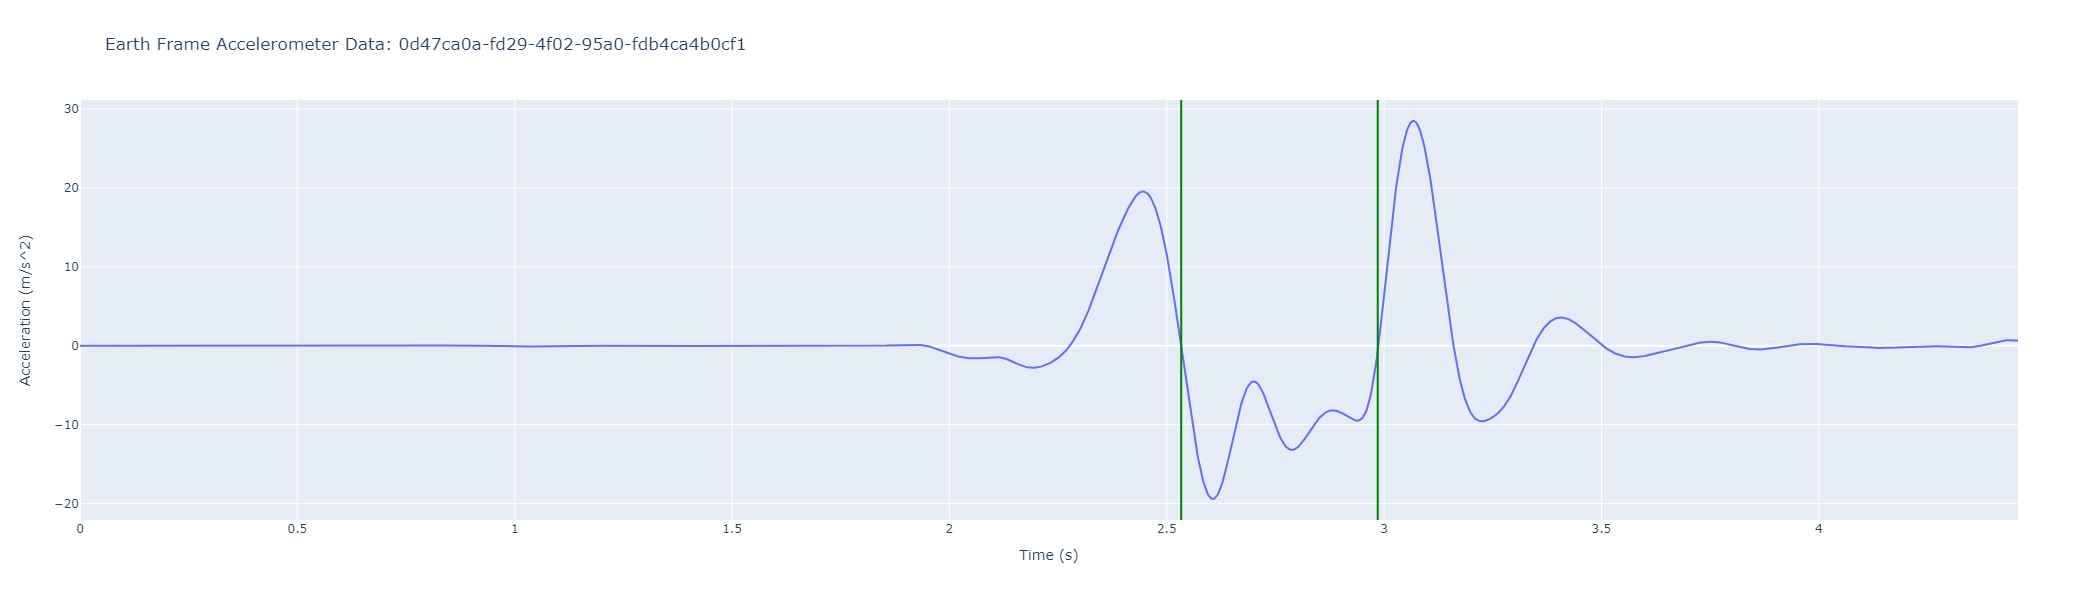

Enter weight here (lbs):  150


Combined data successfully appended to vj_height.csv


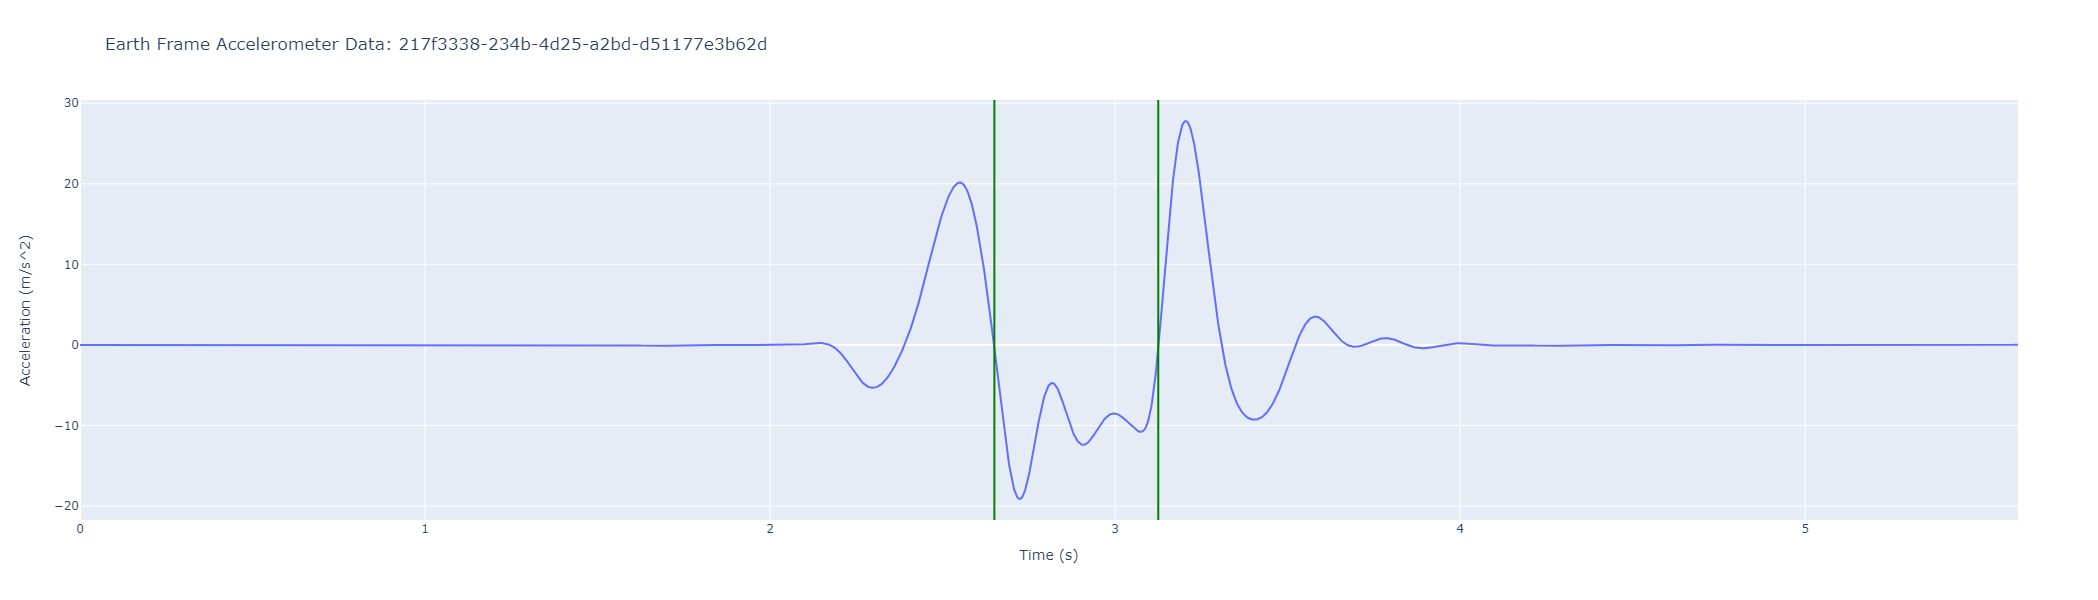

Enter weight here (lbs):  150


Combined data successfully appended to vj_height.csv


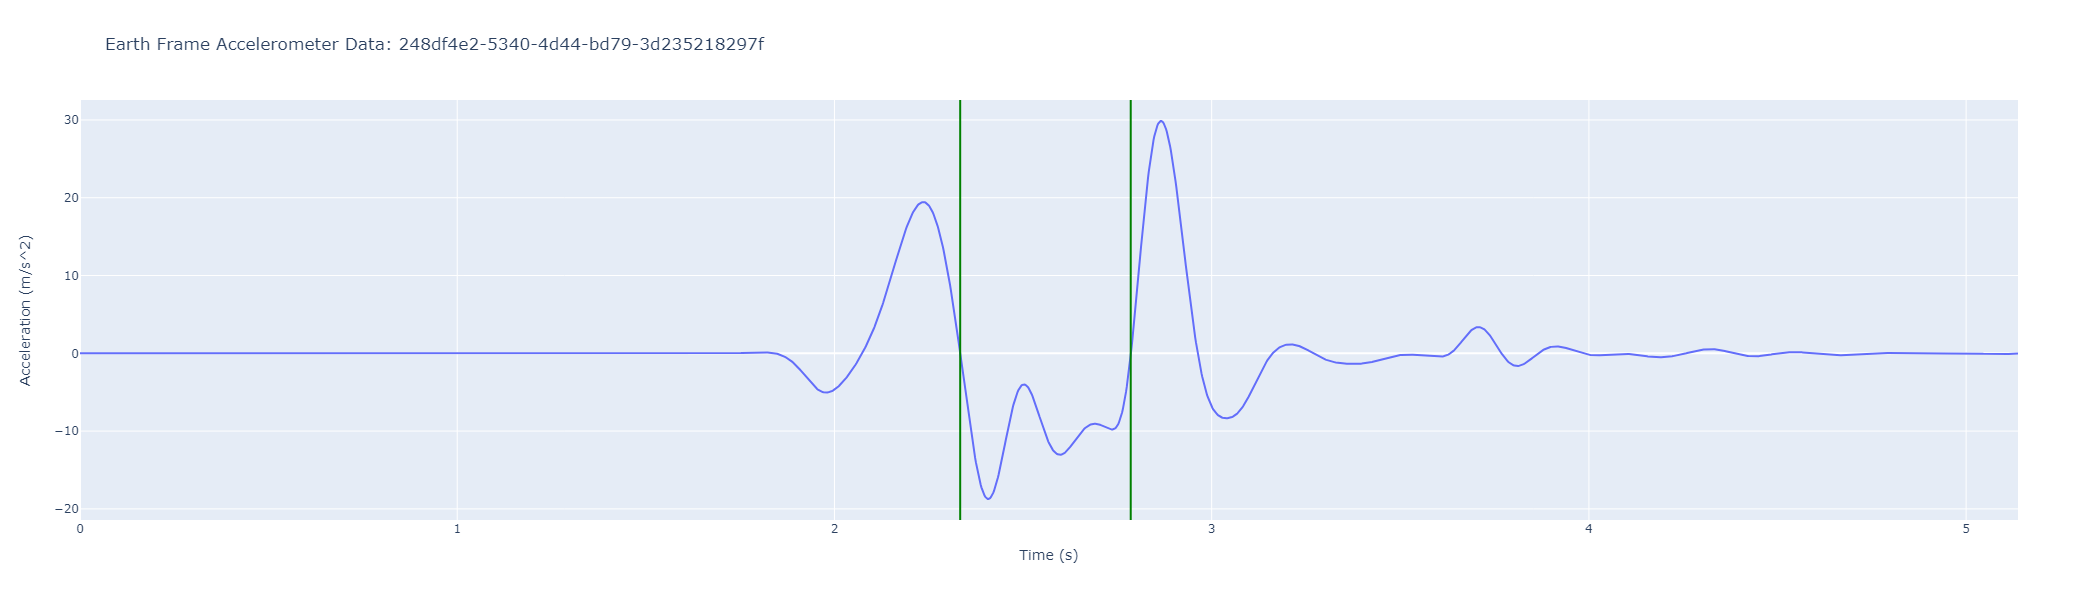

Enter weight here (lbs):  150


Combined data successfully appended to vj_height.csv


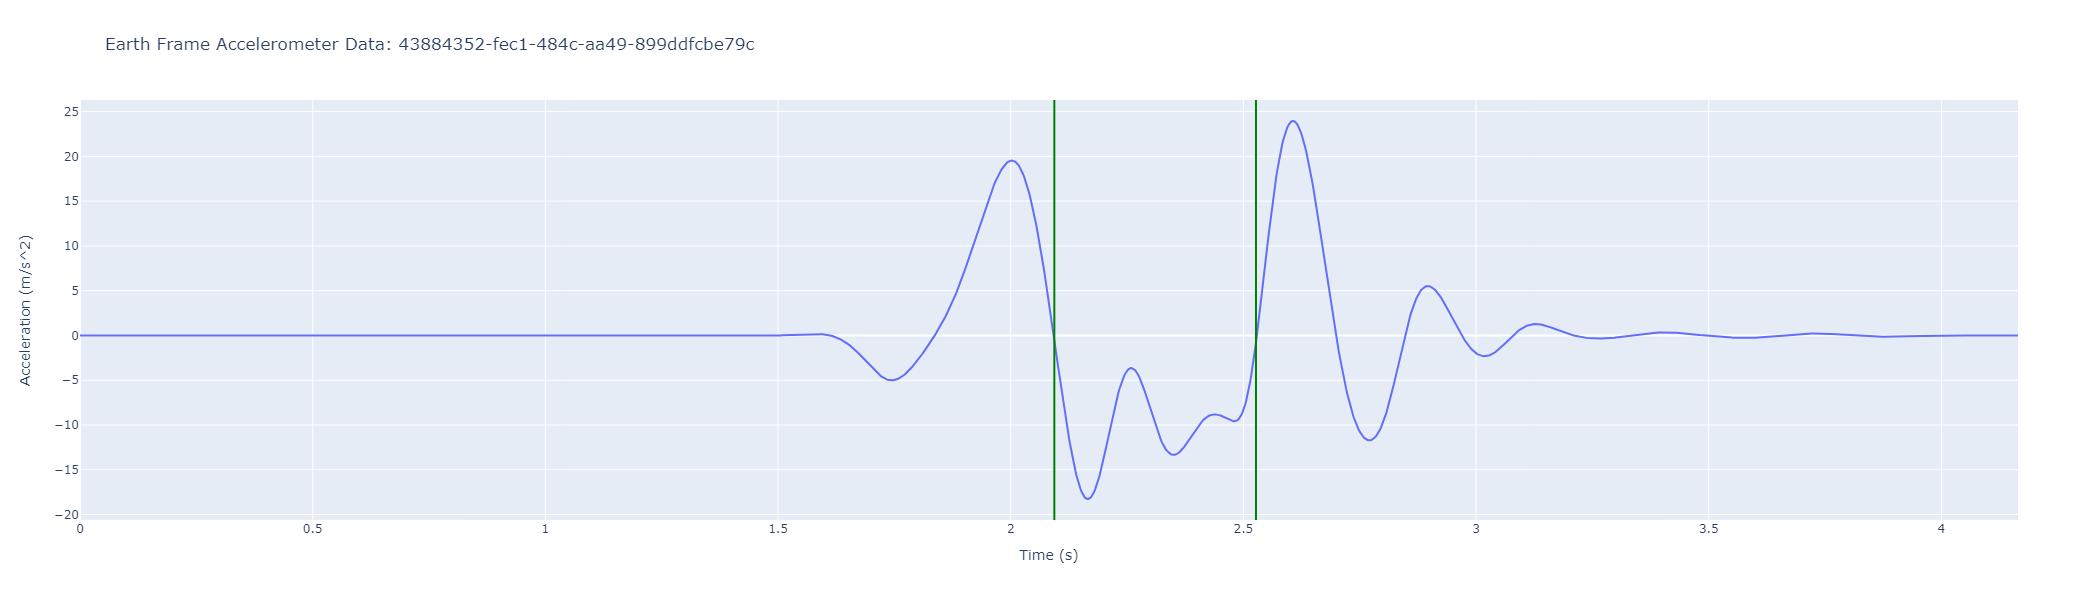

Enter weight here (lbs):  150


Combined data successfully appended to vj_height.csv


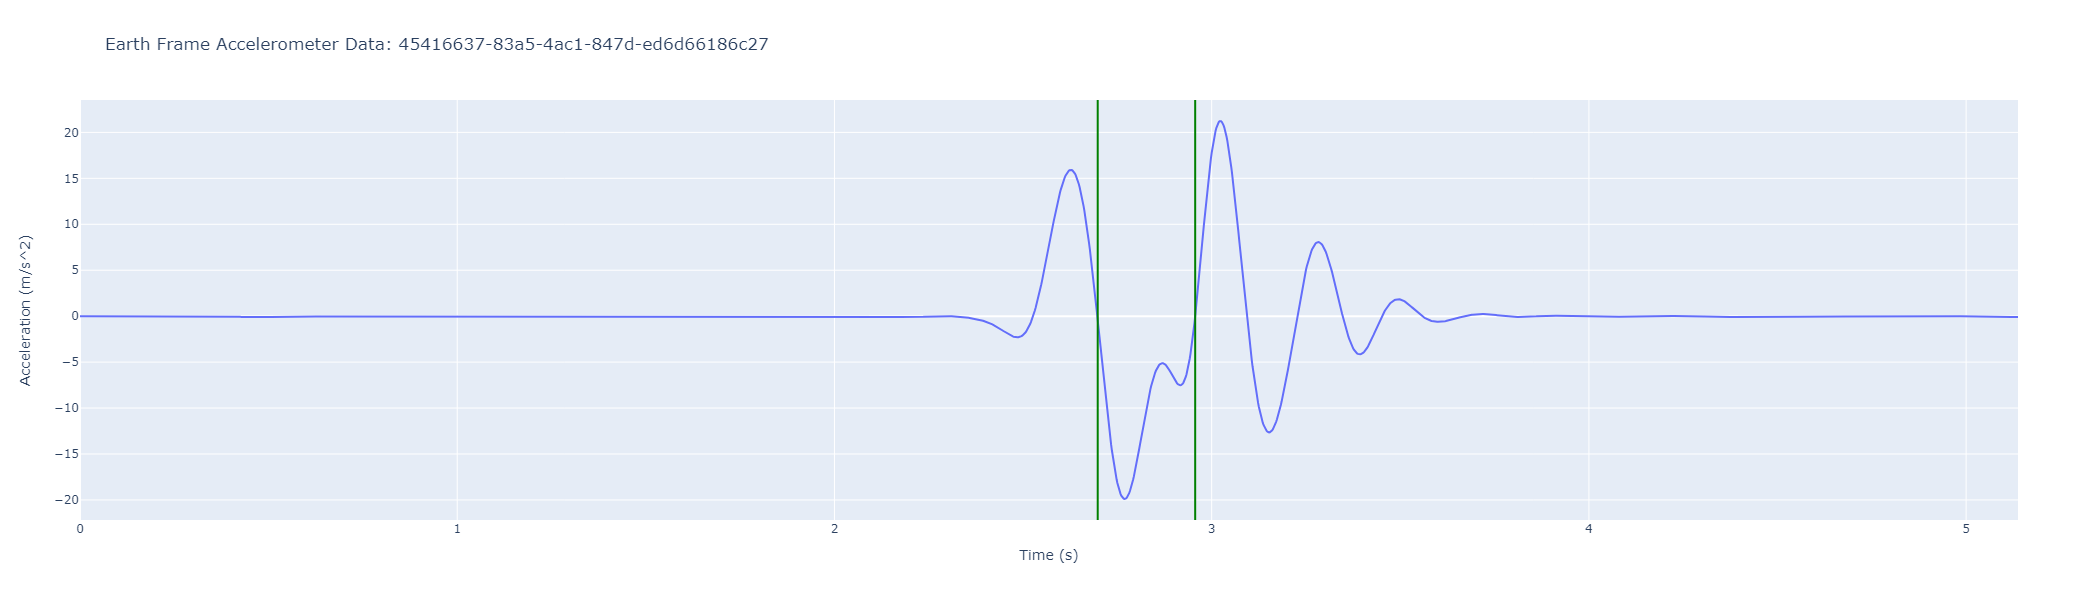

Enter weight here (lbs):  150


Combined data successfully appended to vj_height.csv


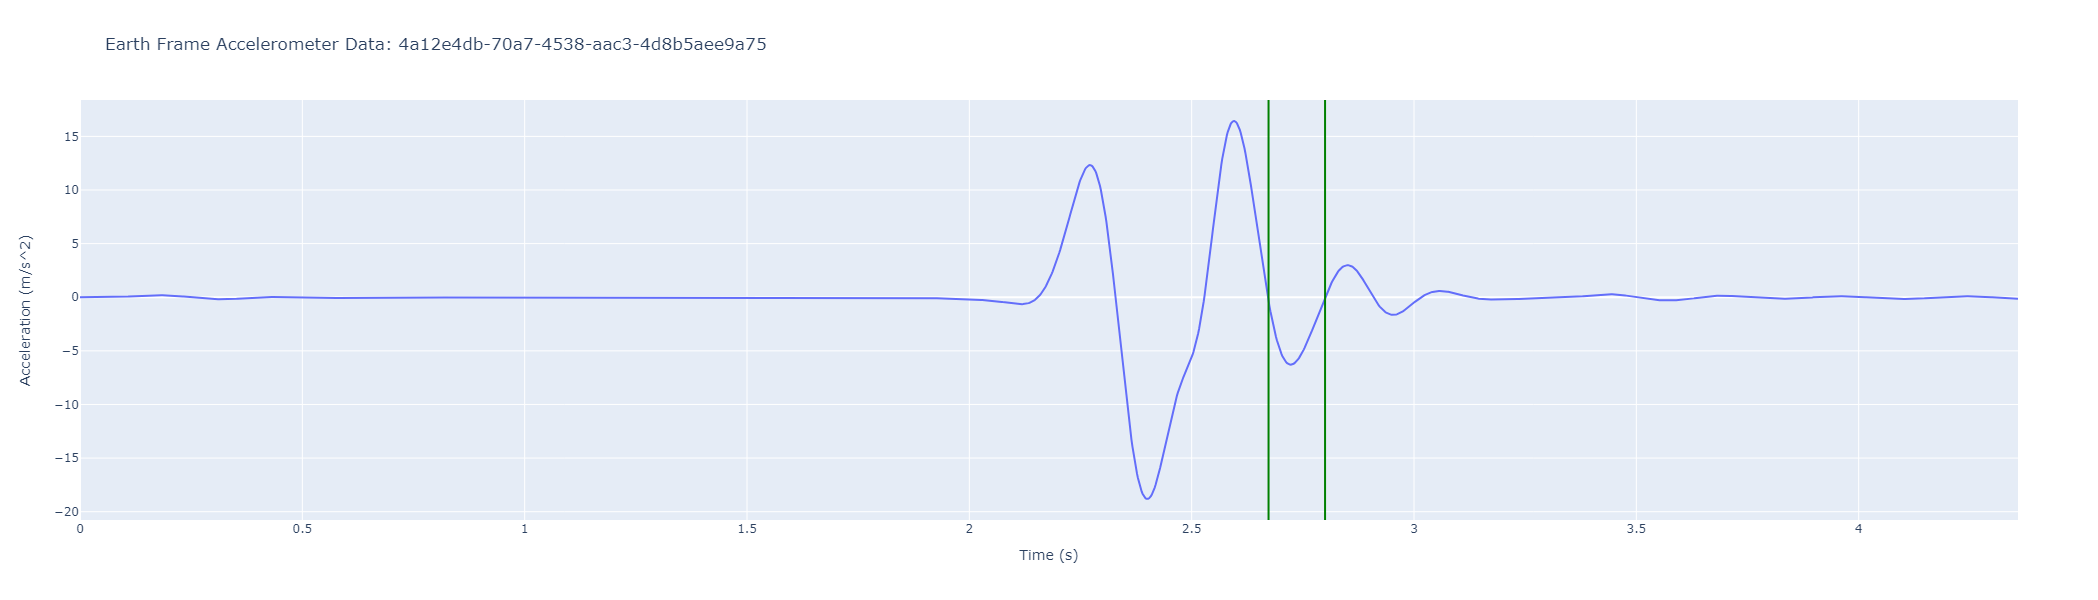

Enter weight here (lbs):  150


Combined data successfully appended to vj_height.csv


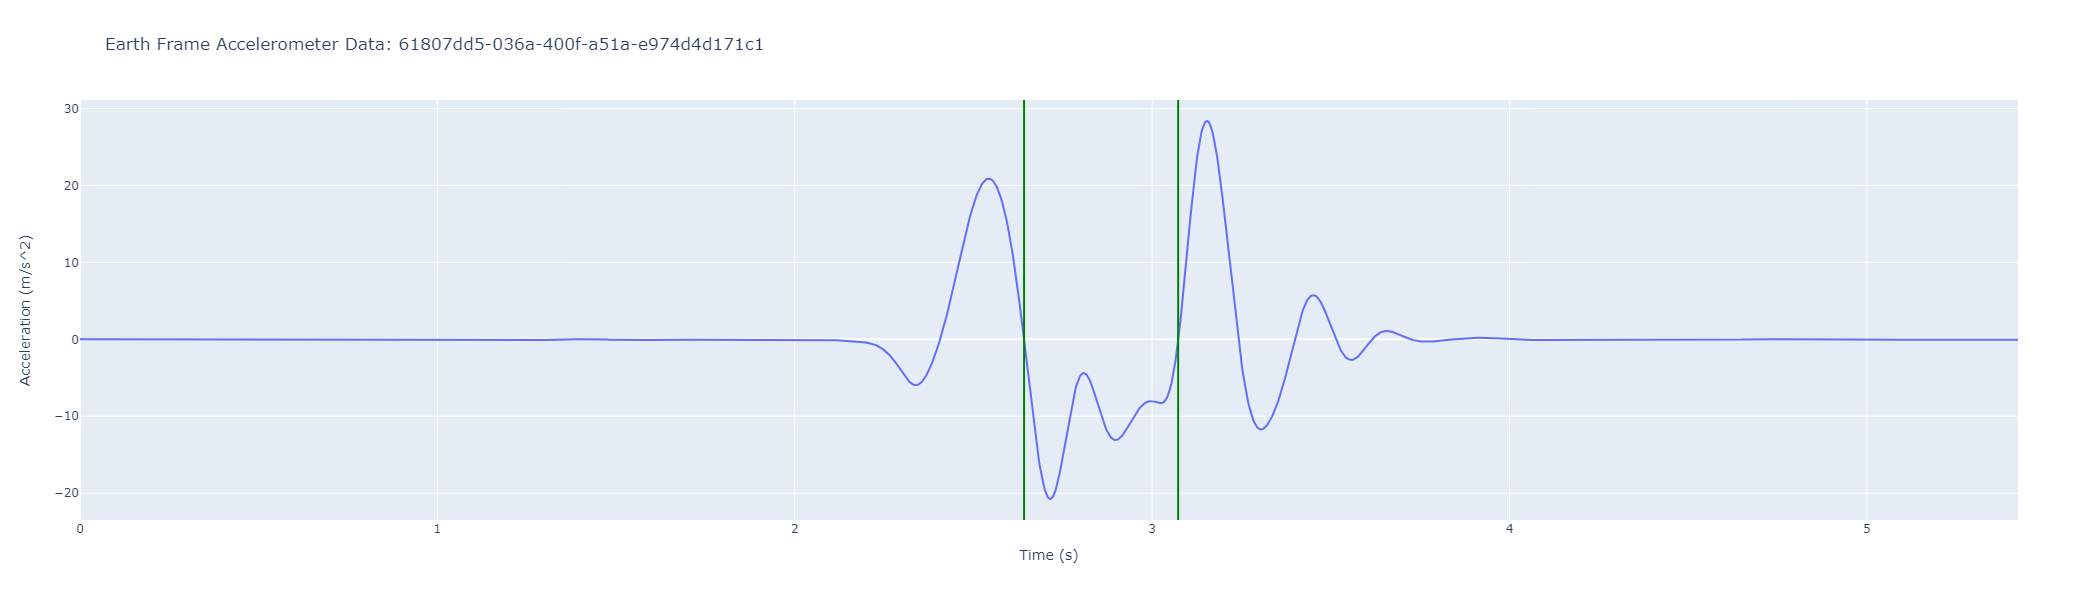

Enter weight here (lbs):  150


Combined data successfully appended to vj_height.csv


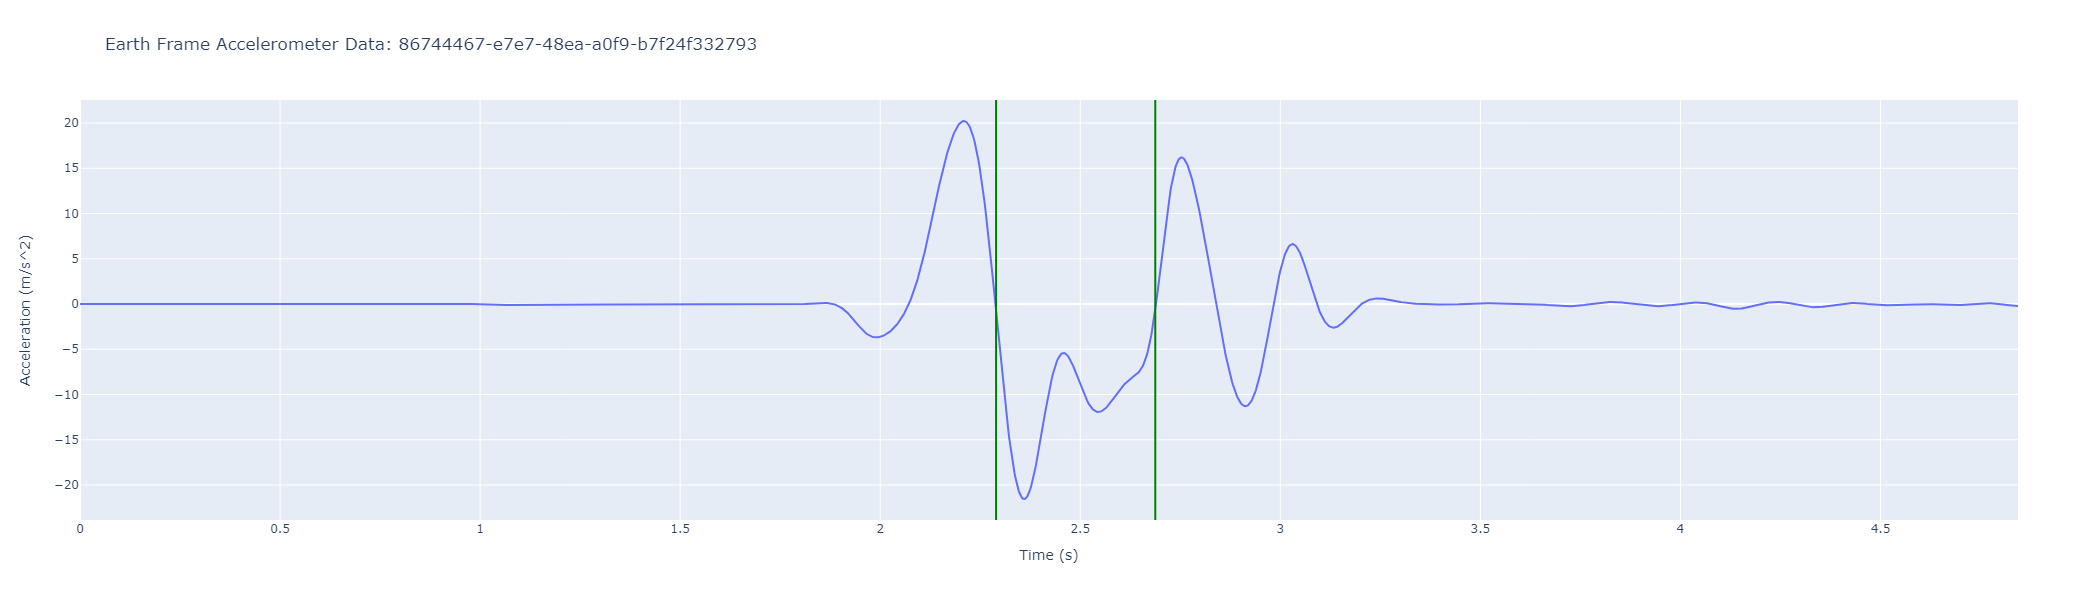

Enter weight here (lbs):  150


Combined data successfully appended to vj_height.csv


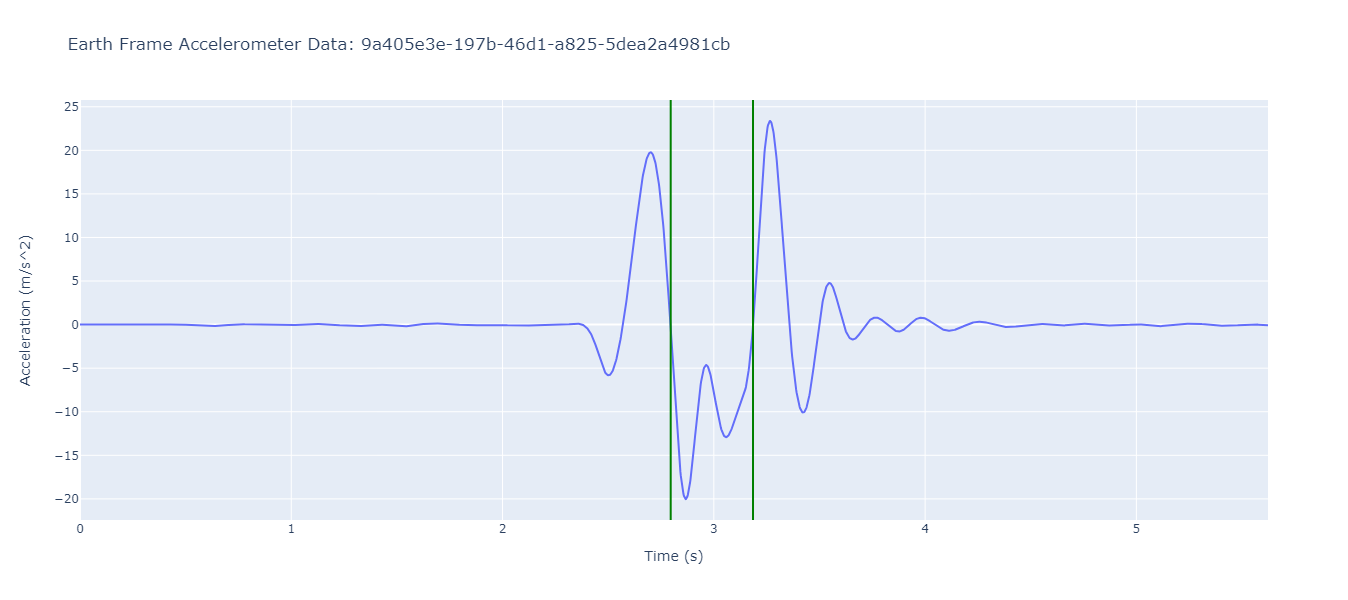

Enter weight here (lbs):  150


Combined data successfully appended to vj_height.csv


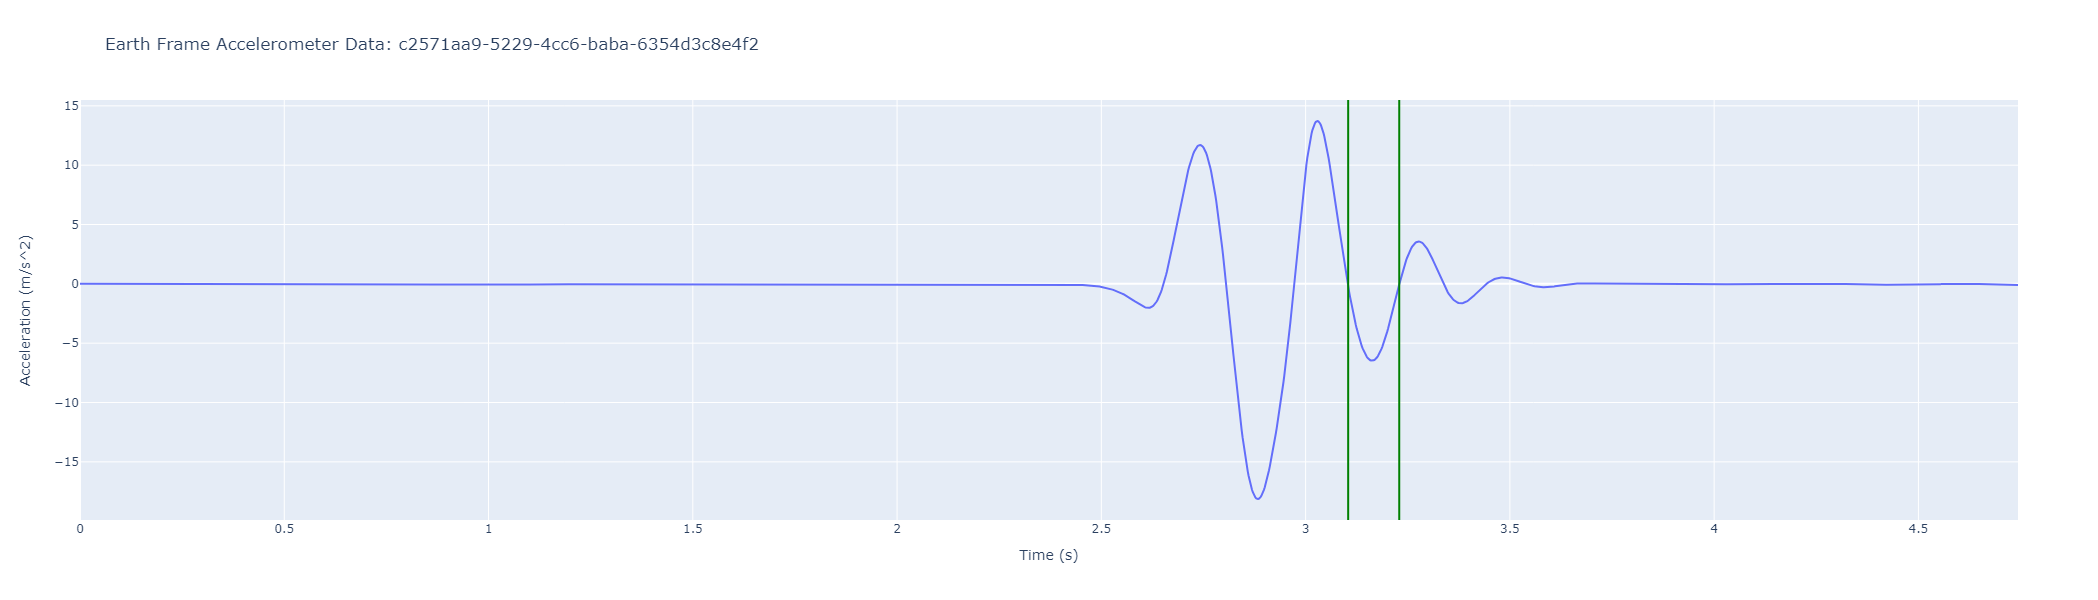

Enter weight here (lbs):  150


Combined data successfully appended to vj_height.csv


In [9]:
sessions = {session: group for session, group in mikoshi_df.groupby('session_id')}
# import vert_jump

pd.options.mode.chained_assignment = None

for id, session in sessions.items():
    results = get_jump_height(id, session, cloud = True)

In [ ]:
# # For writing to big query

# import os
# from google.oauth2 import service_account
# from pandas_gbq import to_gbq, read_gbq
# import pandas as pd
# project_id = 'core-aca65d38'
# dataset_name = 'ed'
# megan_table = 'megan_table'
# CHOOSE_YOUR_DESTINATION_TABLE = megan_table      # CHOOSE YOUR TABLE DESTINATION HERE
# destination_table = f'{project_id}.{dataset_name}.{CHOOSE_YOUR_DESTINATION_TABLE}'
# rel_cred_path = "/home/jupyter/local/big_query_example/key.json"  # Adjust as per your directory structure
# cred_path = os.path.abspath(rel_cred_path)
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = cred_path
# credentials = service_account.Credentials.from_service_account_file(cred_path)

# big_df = pd.read_csv('vj_height.csv')

# try:
#     to_gbq(
#         big_df, # CHANGE TO YOUR DF THAT YOU WANT TO PUT MEGAN
#         destination_table,
#         project_id=project_id,
#         if_exists='replace',
#         credentials=credentials
#     )
#     print("Data successfully written to BigQuery!")
# except Exception as e:
#     print(f"Error writing to BigQuery: {str(e)}")